In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import CosineAnnealingLR
import pickle
import os
import matplotlib.pyplot as plt


# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

from ph1 import *
from load_cifar10 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

reset_seed(0)

2.4.1
cuda


In [3]:
to_float= torch.float
to_long = torch.long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir='./datasets'
loader_train, loader_val, loader_test = load_CIFAR10(data_dir, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


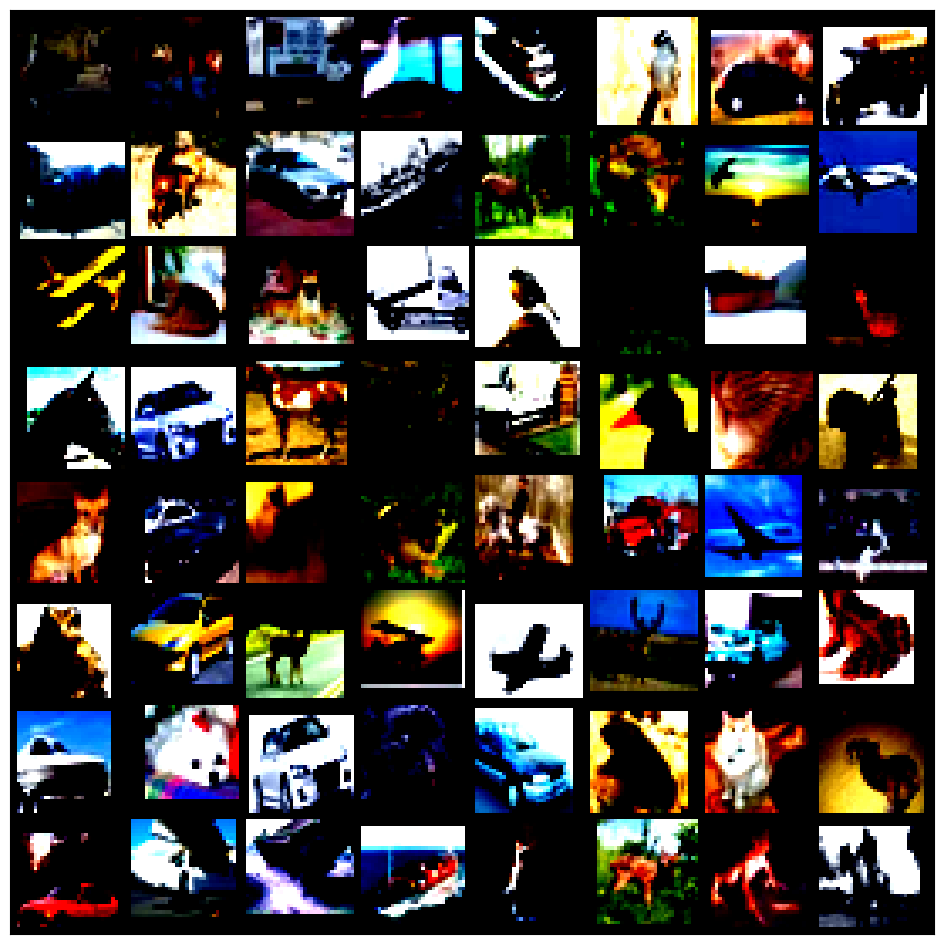

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(loader_train)

In [6]:
networks = {
    'best': {
        'block': ResidualBlock,
        'stage_args': [
            (32, 64, 2, False),
            (64, 128, 2, True),
            (128, 256, 2, True),
            (256, 512, 2, True)
        ],
        'dropout': True,  # Enable dropout
        'p': 0.4  # Dropout probability
    }
}

def get_resnet(name):
  return ResNet(**networks[name])
# Hook and visualization utilities
layer_outputs = {}

def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(
                lambda module, input, output, name=name: layer_outputs.update({name: output})
            )

def visualize_feature_maps(feature_maps, title_prefix=""):
    batch_size, num_channels, height, width = feature_maps.shape
    nrows = (min(8, num_channels) + 3) // 4  # Adjust the layout to fit up to 8 maps
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(16, 4 * nrows))
    axes = axes.flatten()

    for i in range(min(8, num_channels)):
        axes[i].imshow(feature_maps[0, i].cpu().detach().numpy(), cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(f"{title_prefix} - FM {i+1}")

    for j in range(min(8, num_channels), len(axes)):
        axes[j].axis("off")  # Hide any unused subplots

    plt.tight_layout()
    plt.show()



Resuming training from checkpoint: ./checkpoint/best_1.pth


/tmp/ipykernel_6995/539886231.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


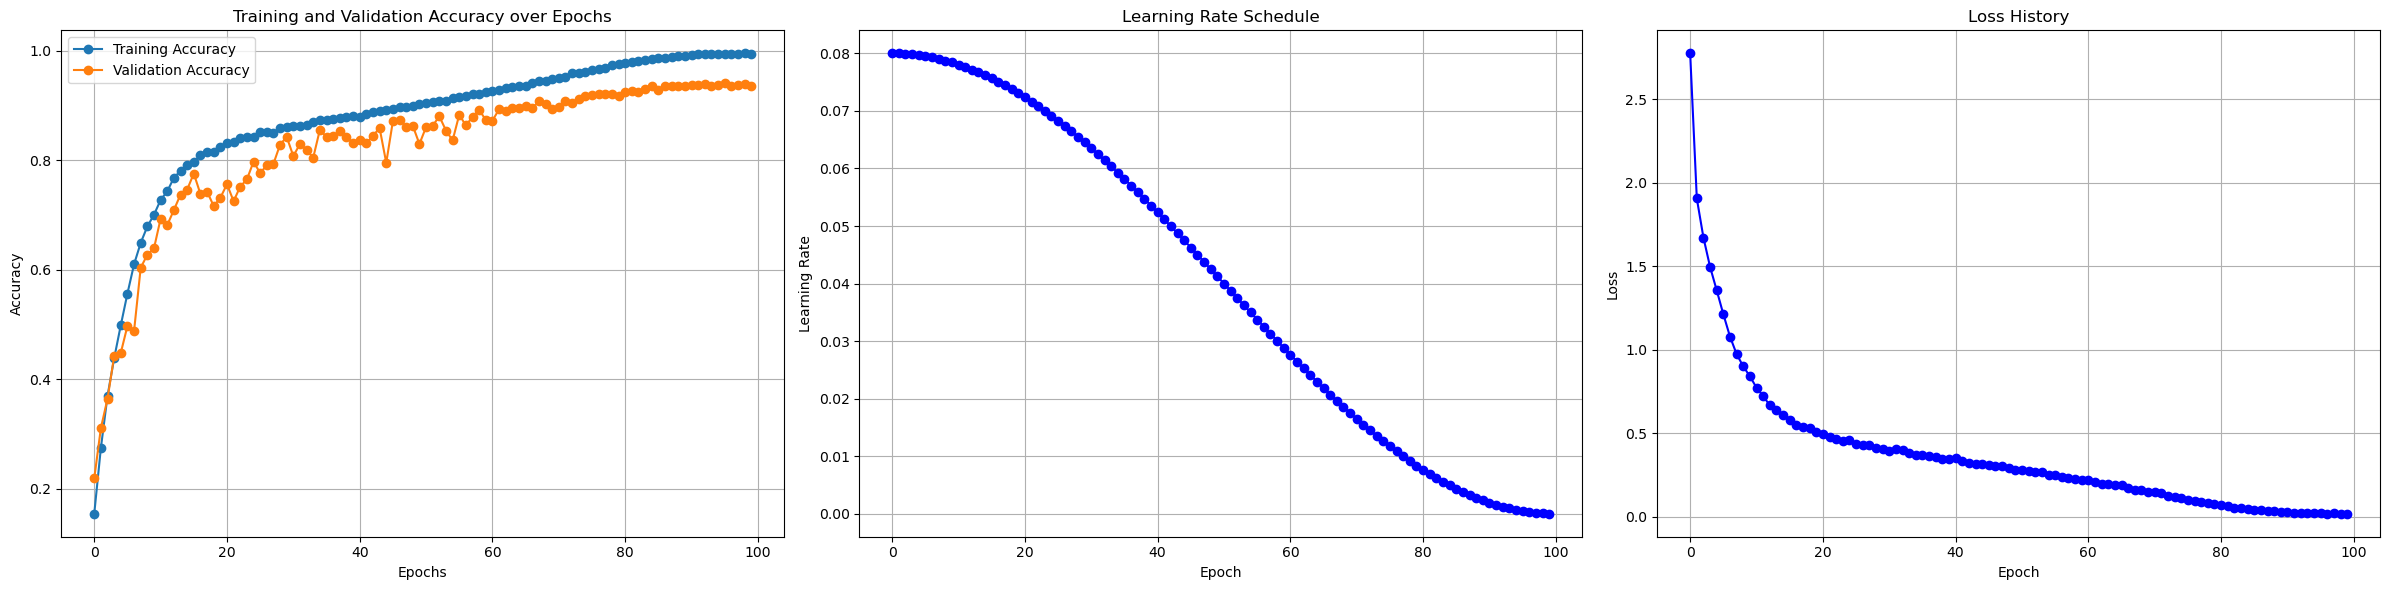

Test accuracy: 9429 / 10000 (94.29%)


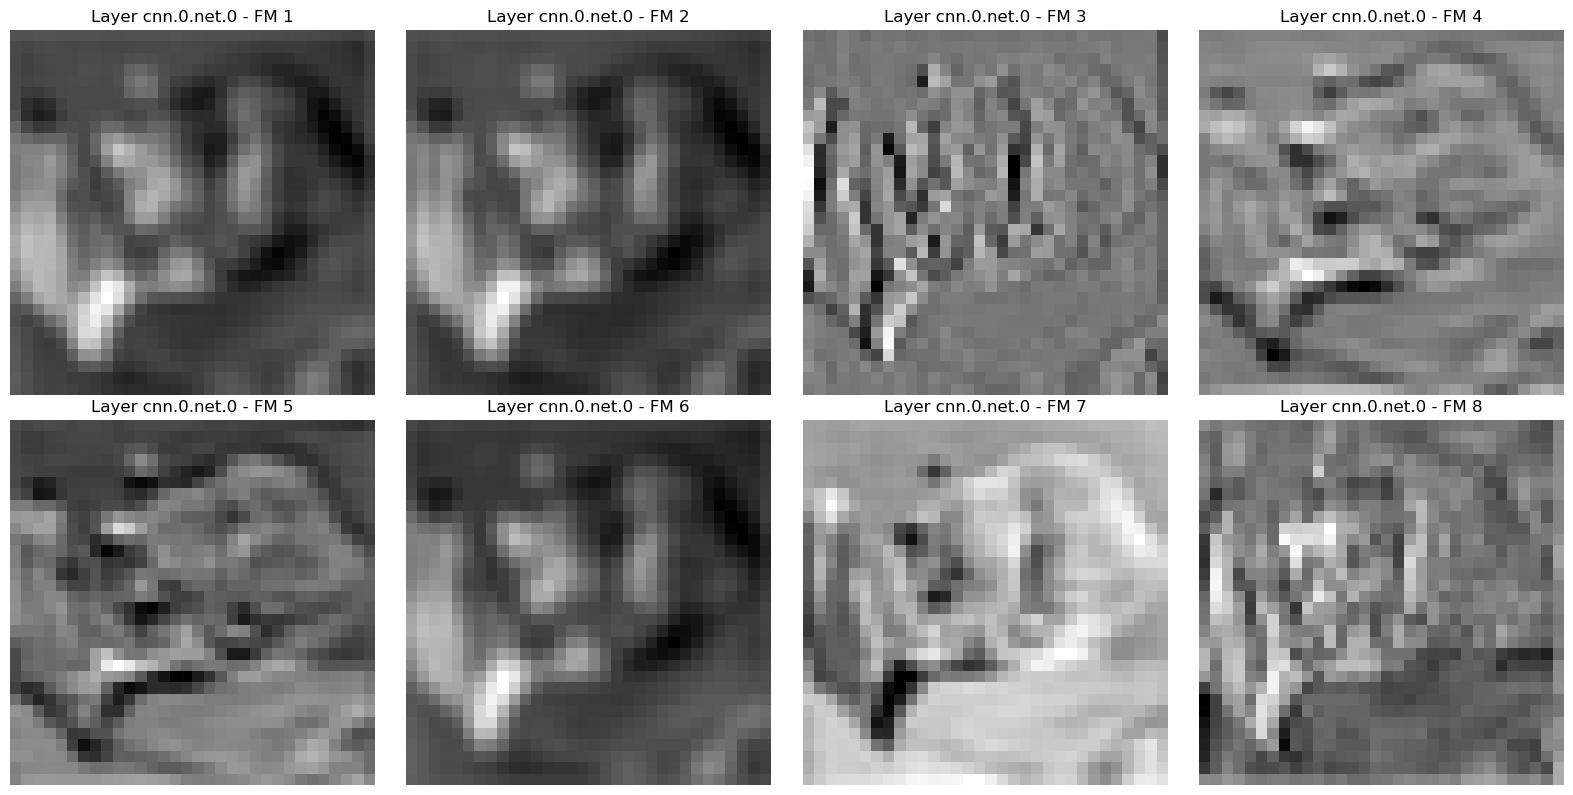

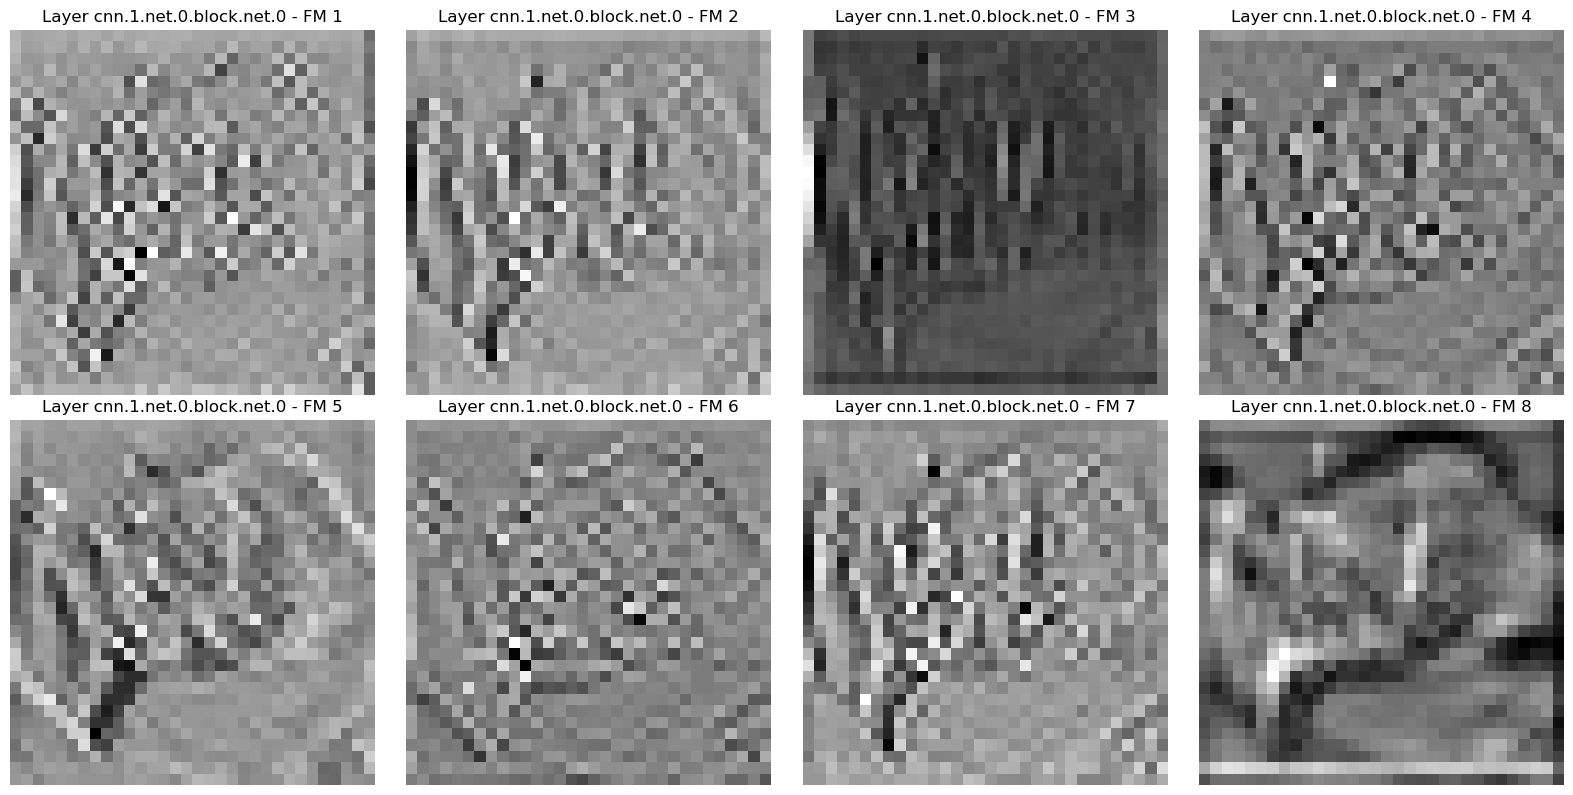

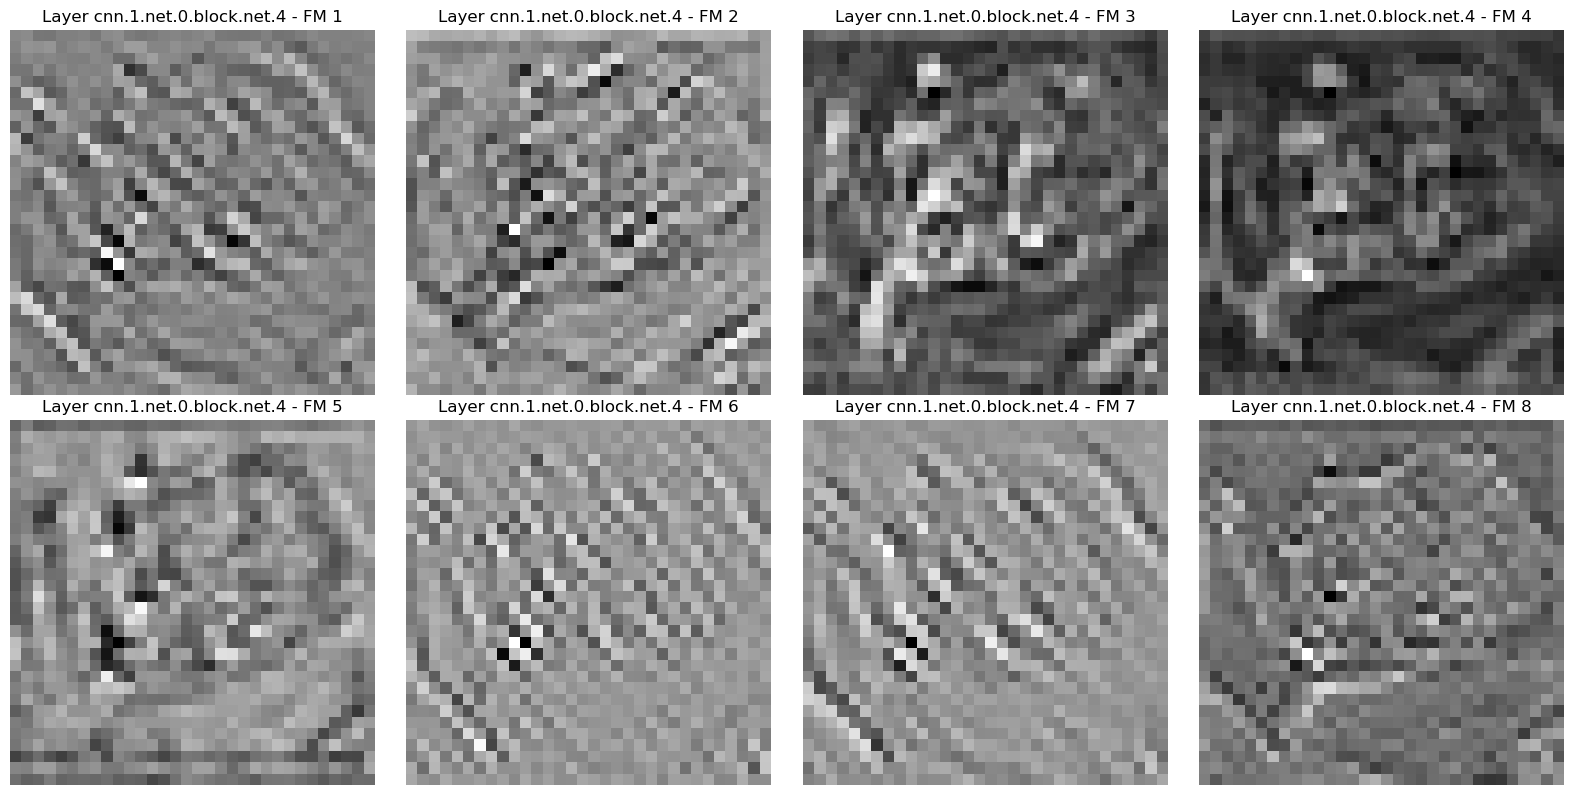

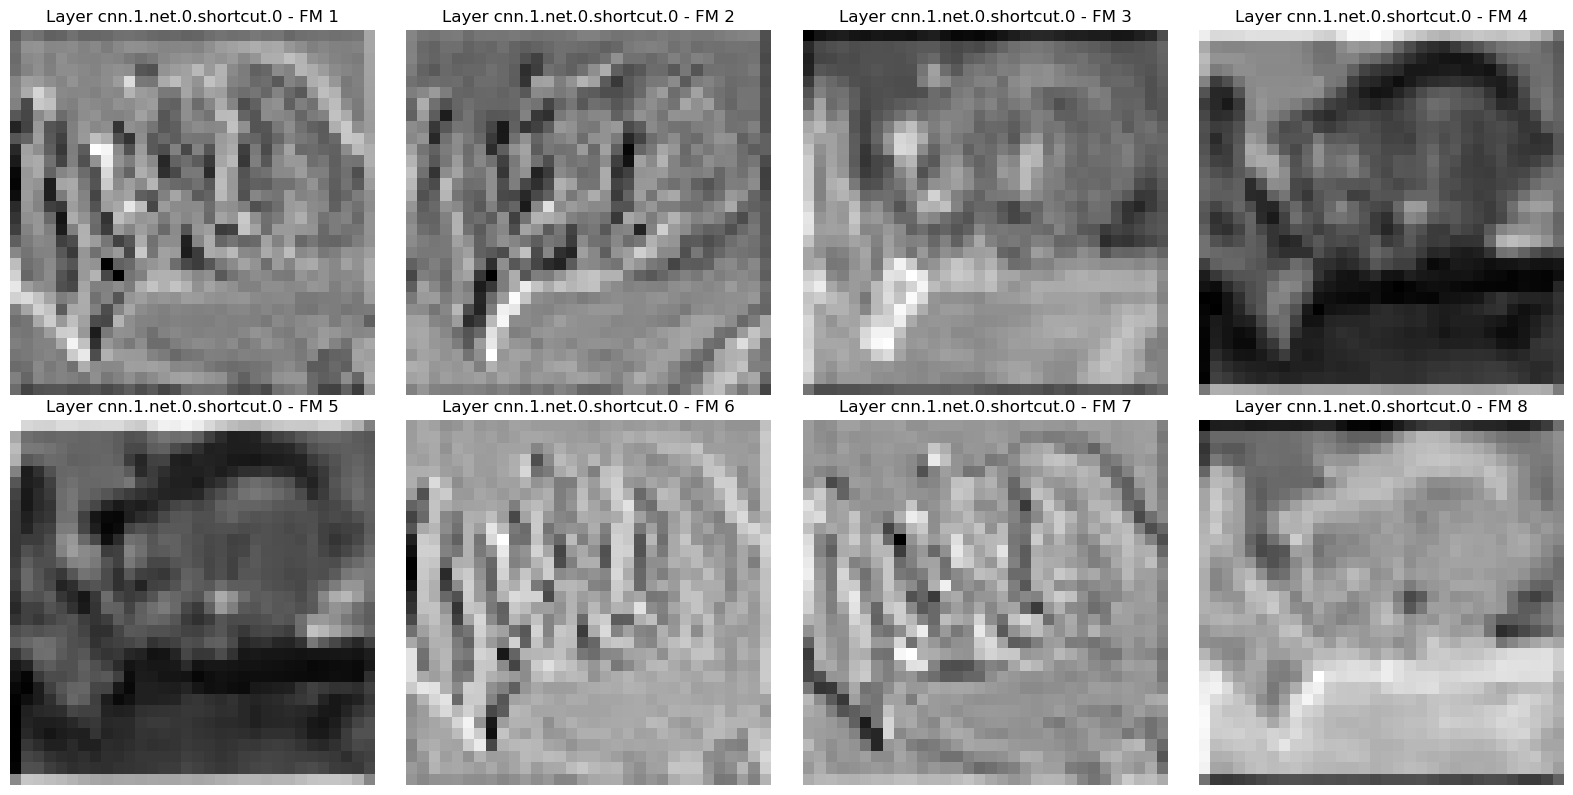

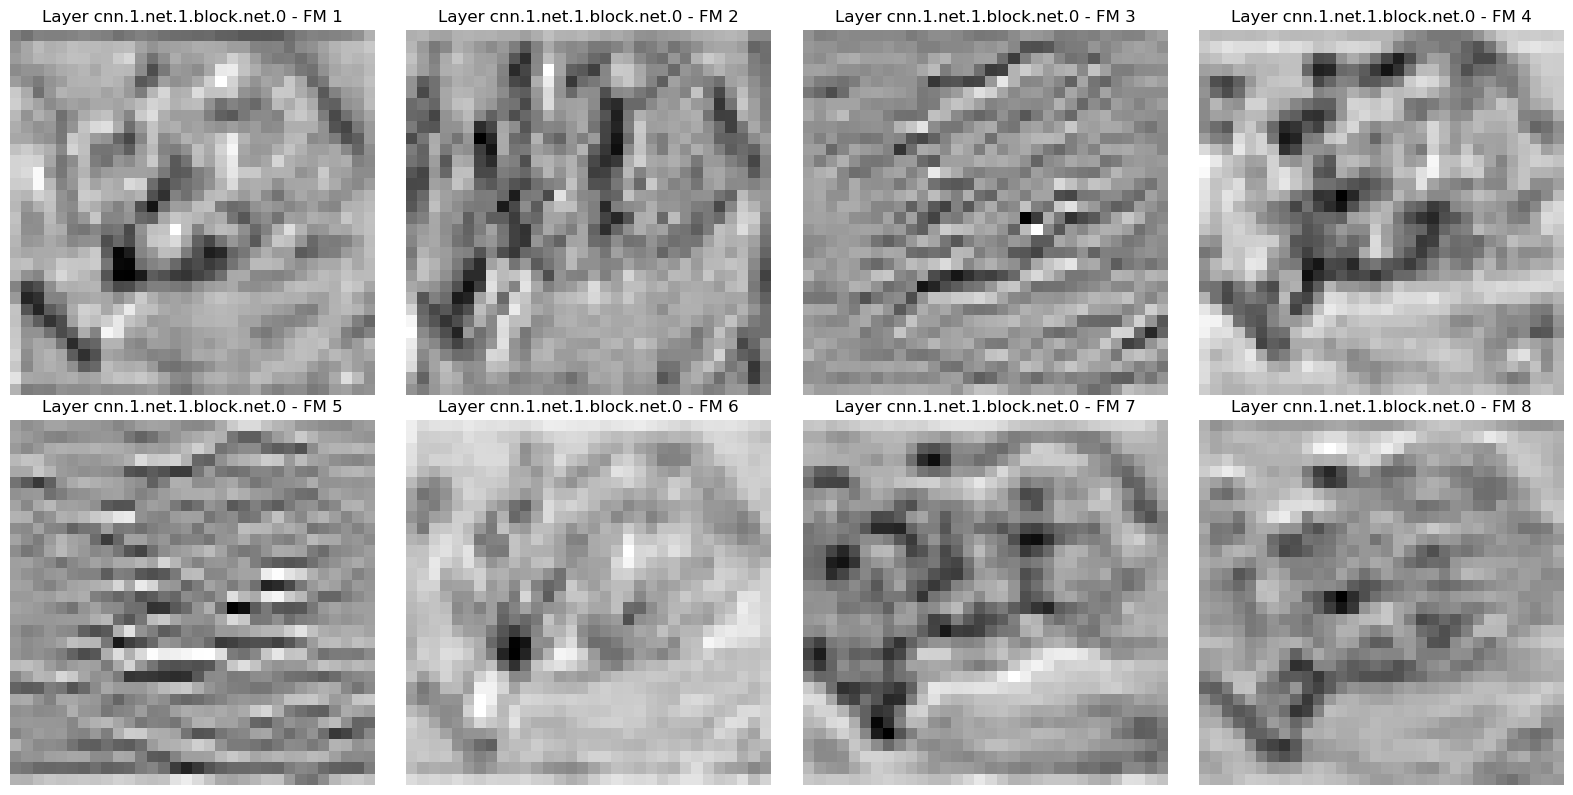

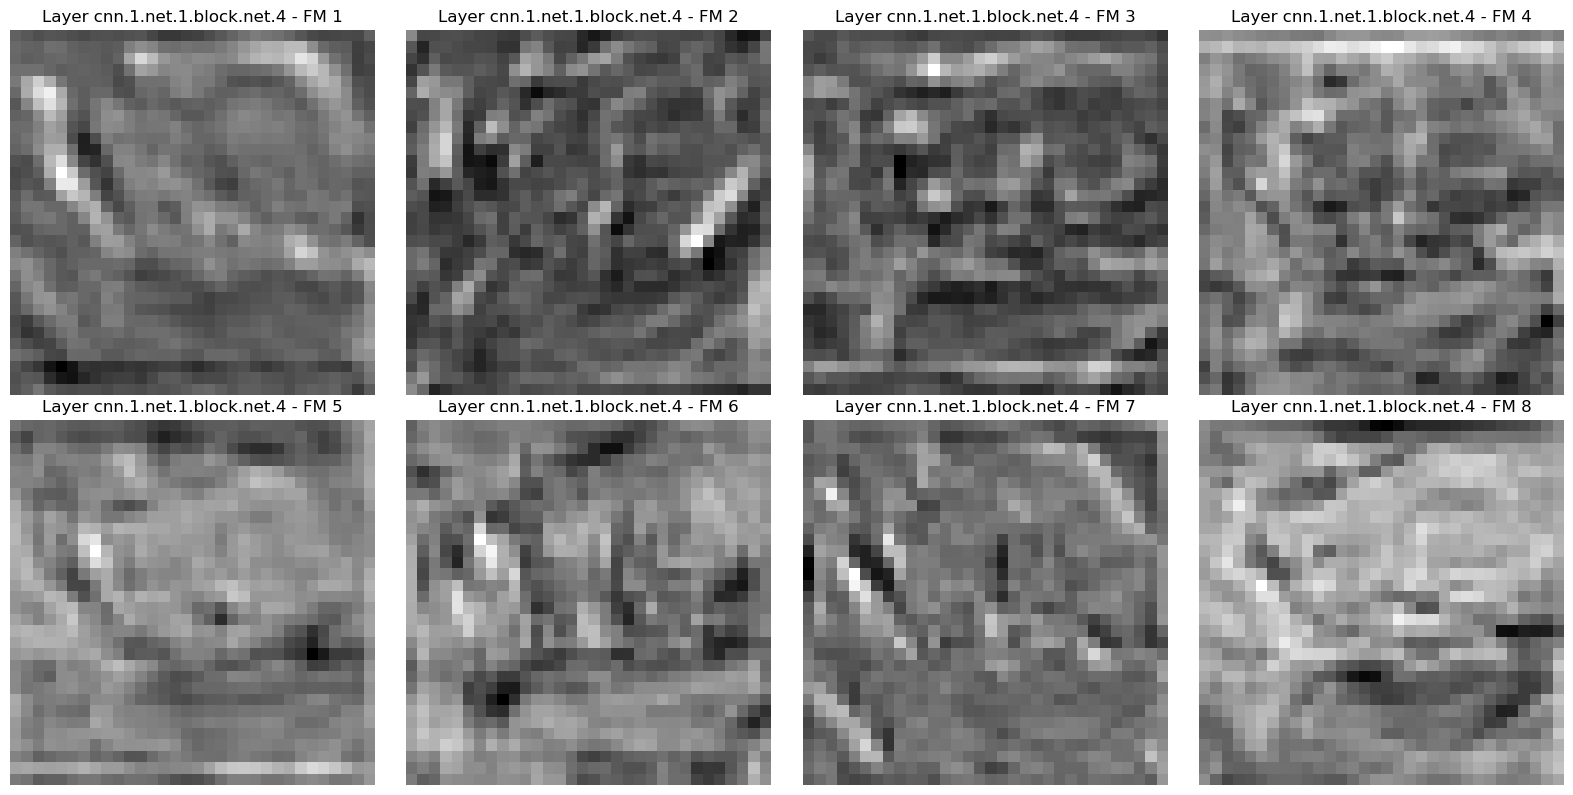

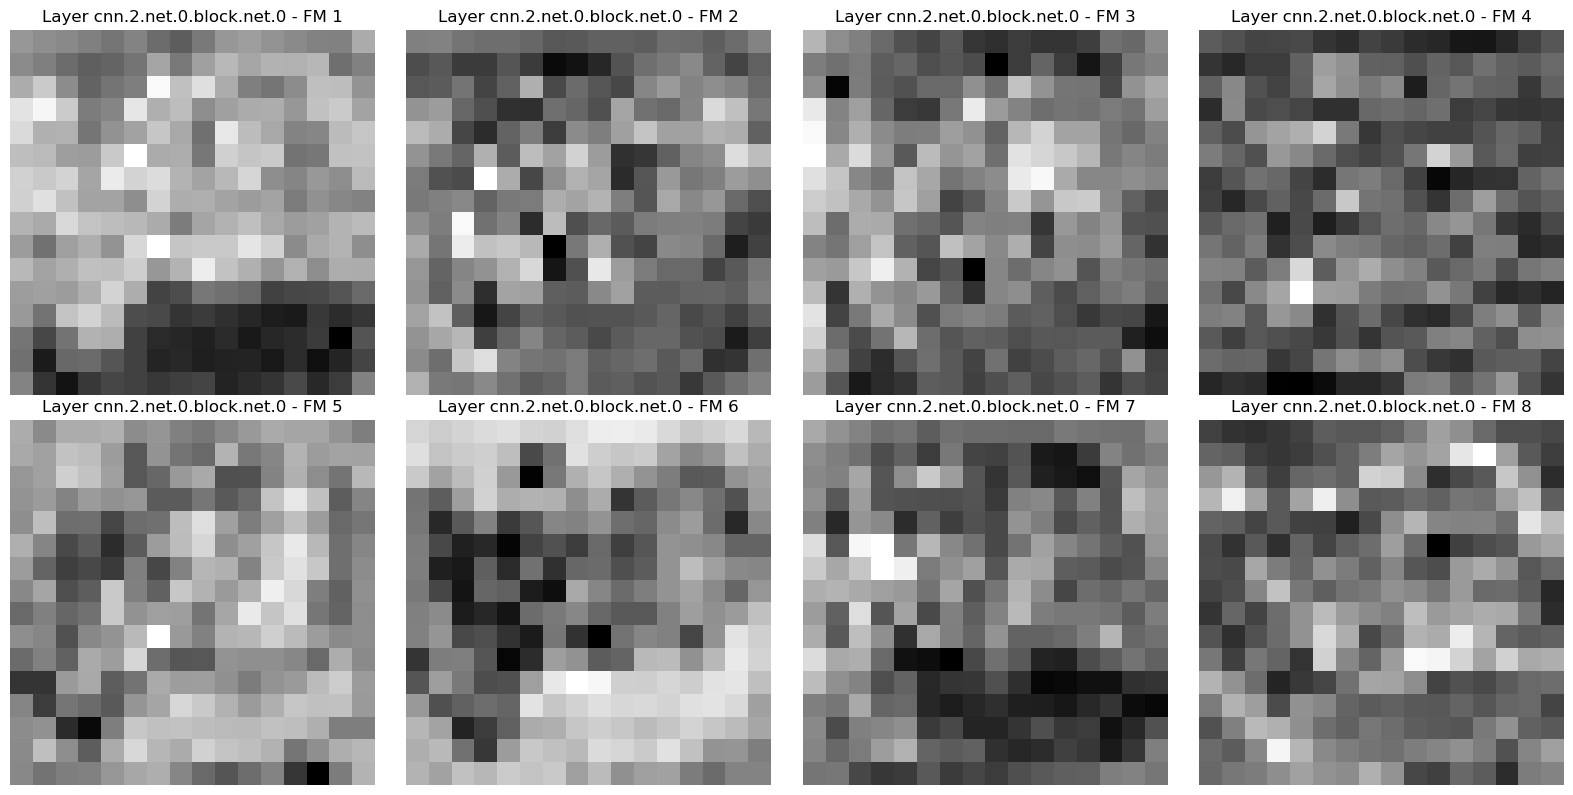

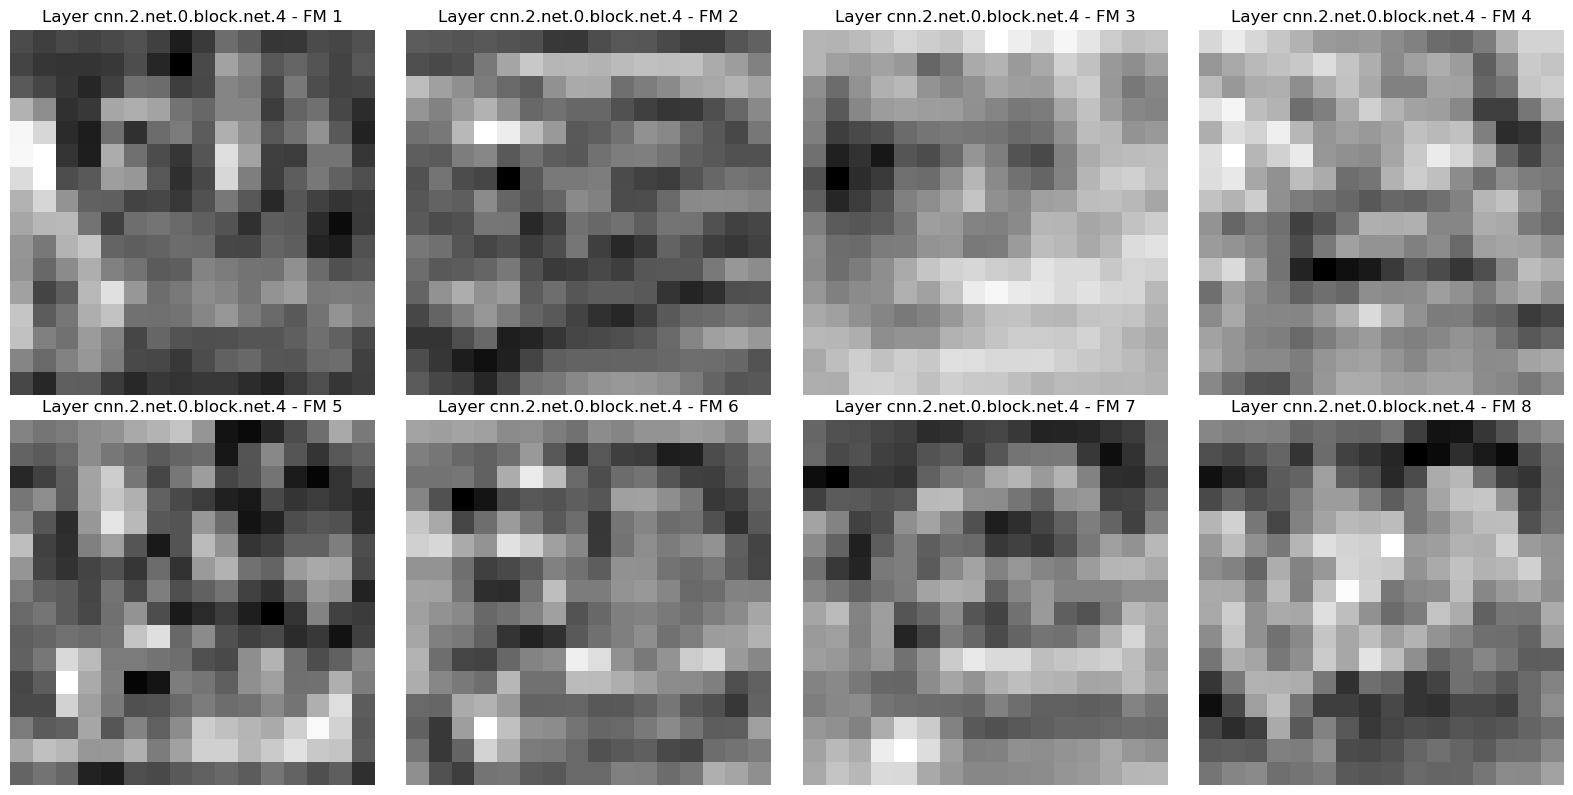

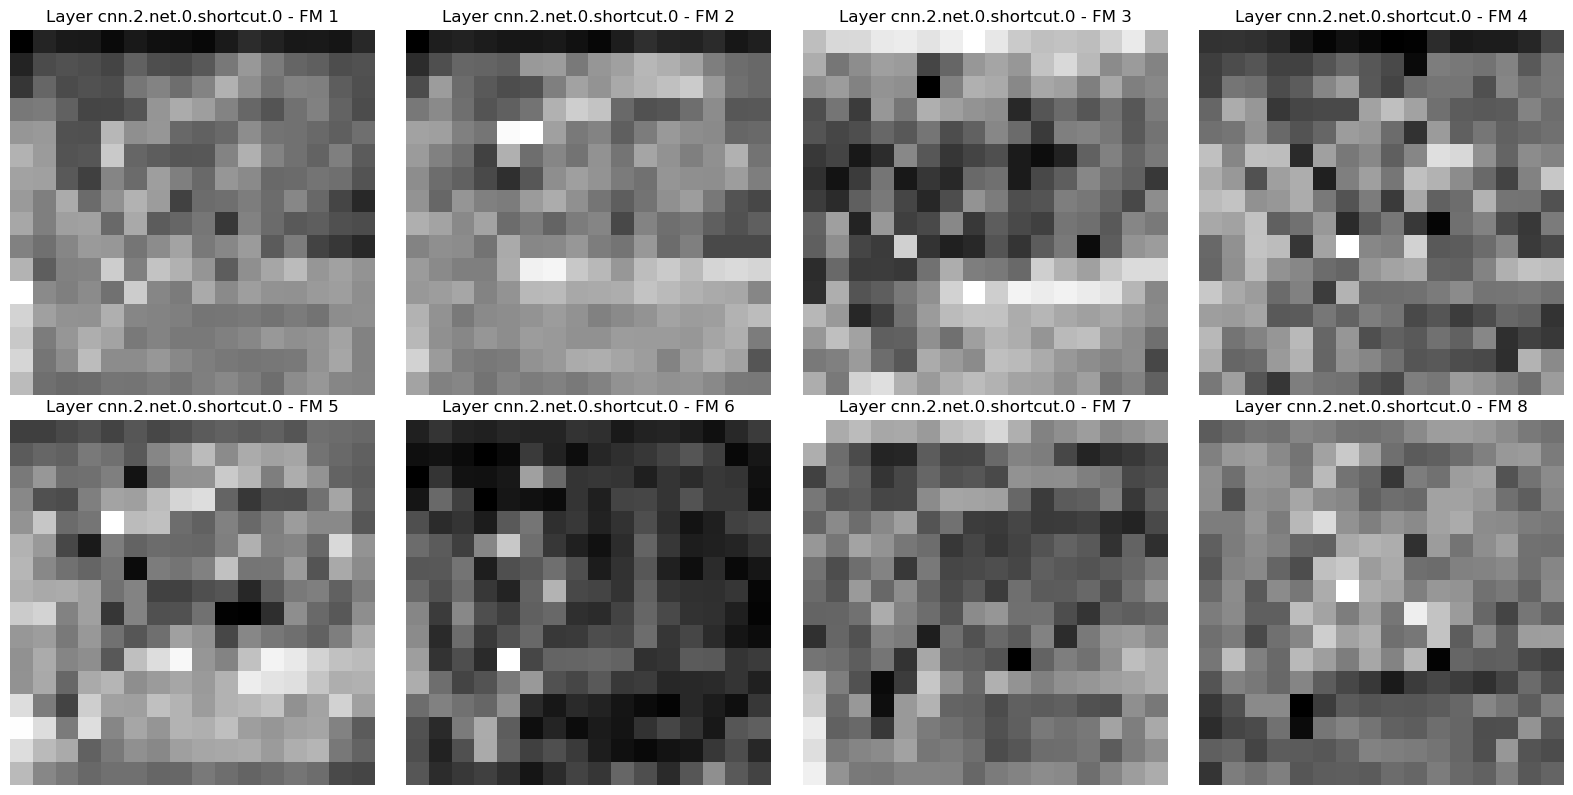

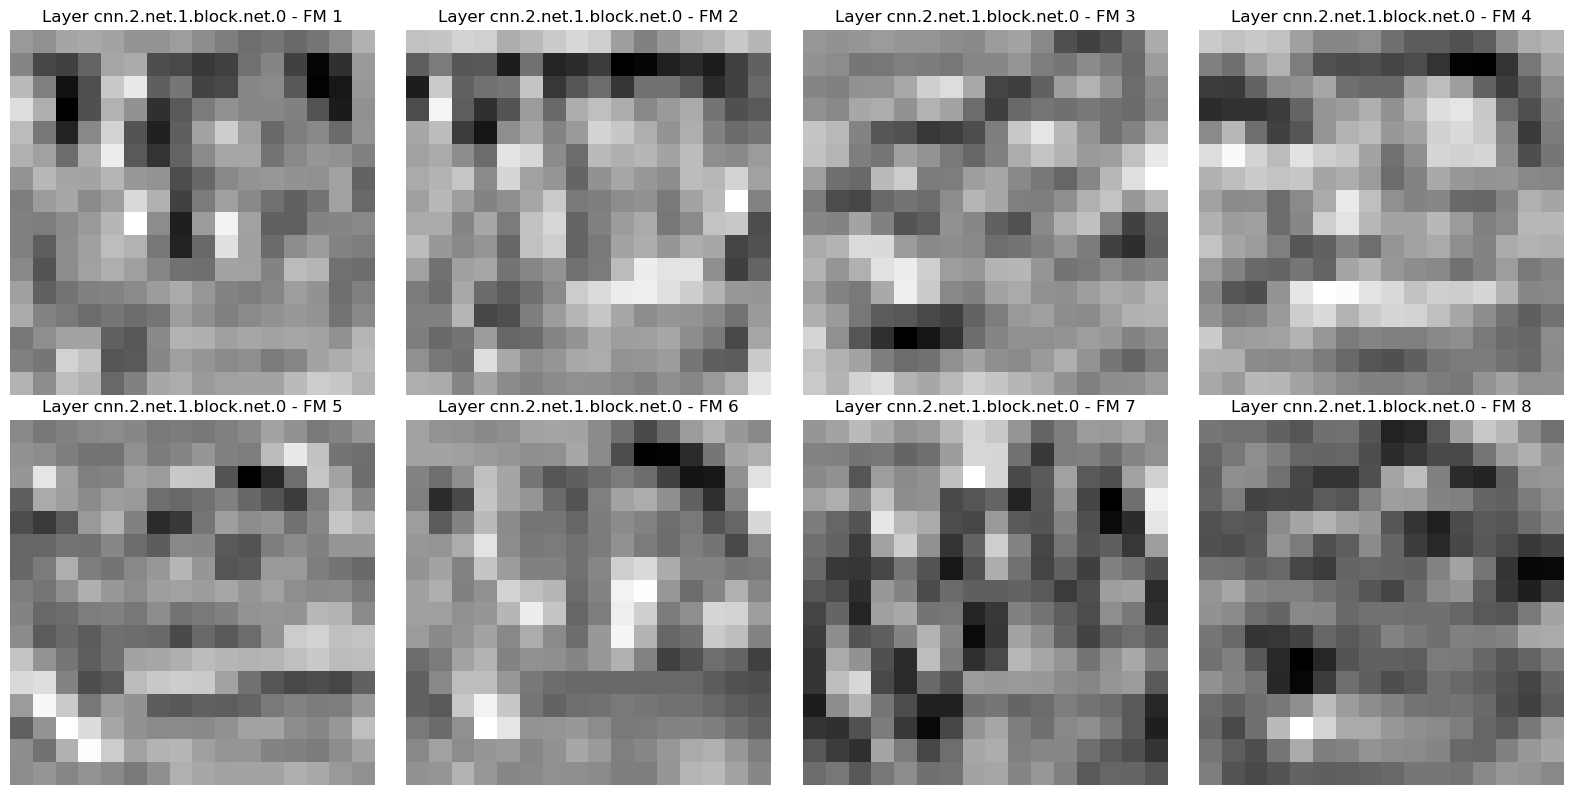

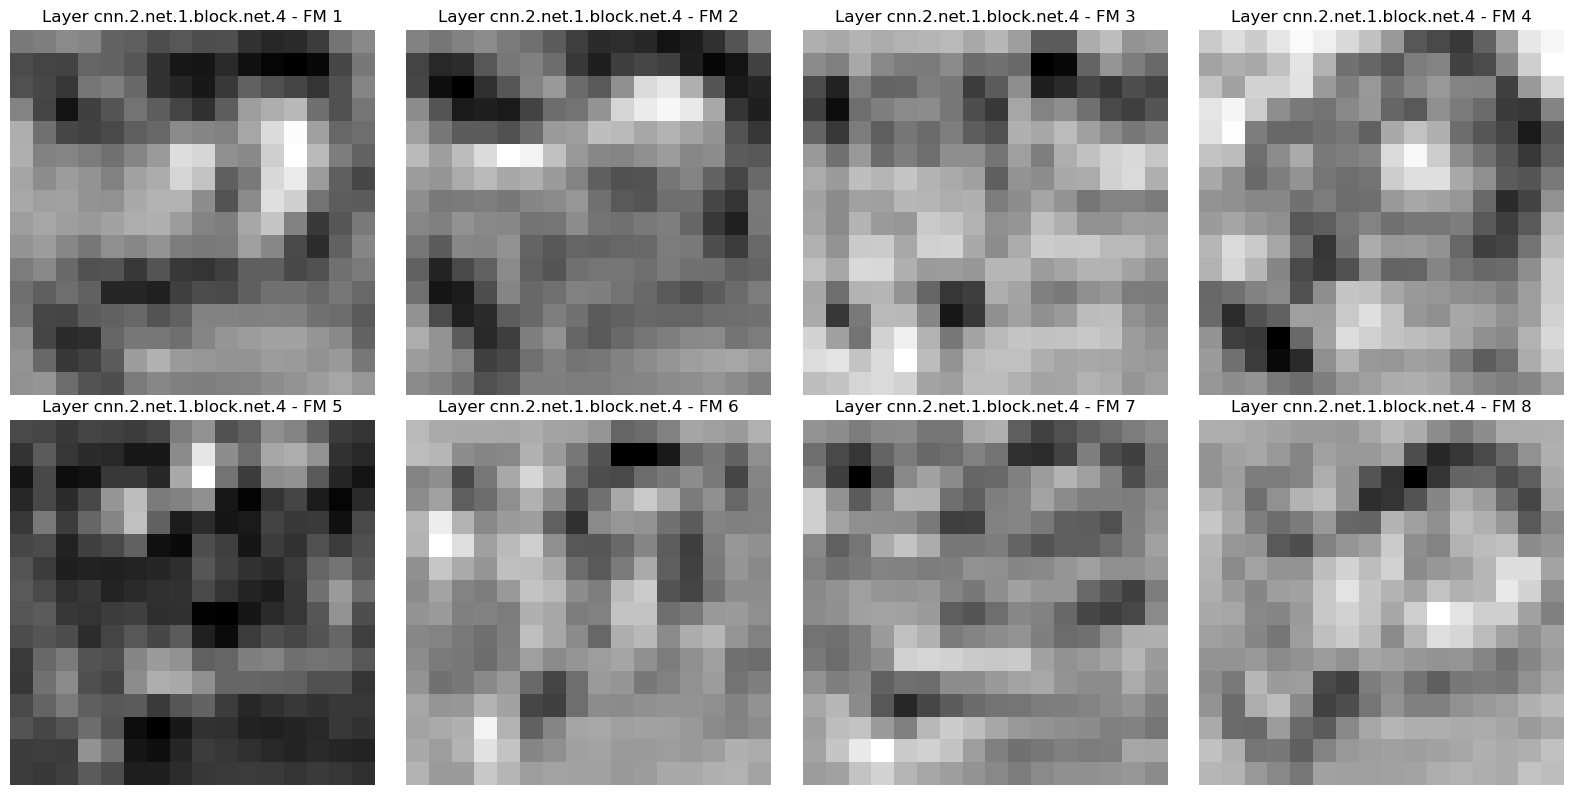

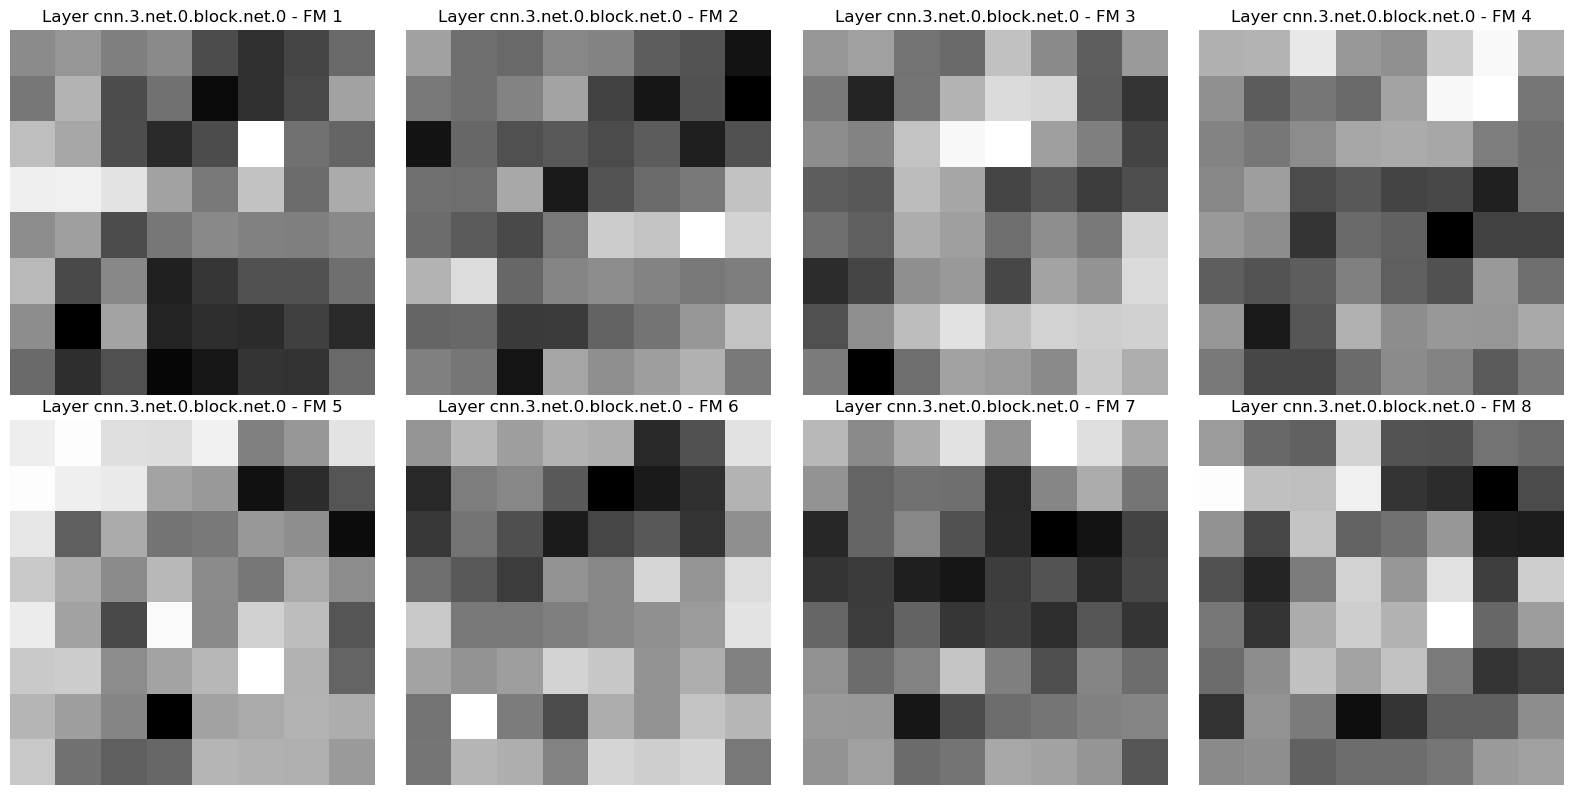

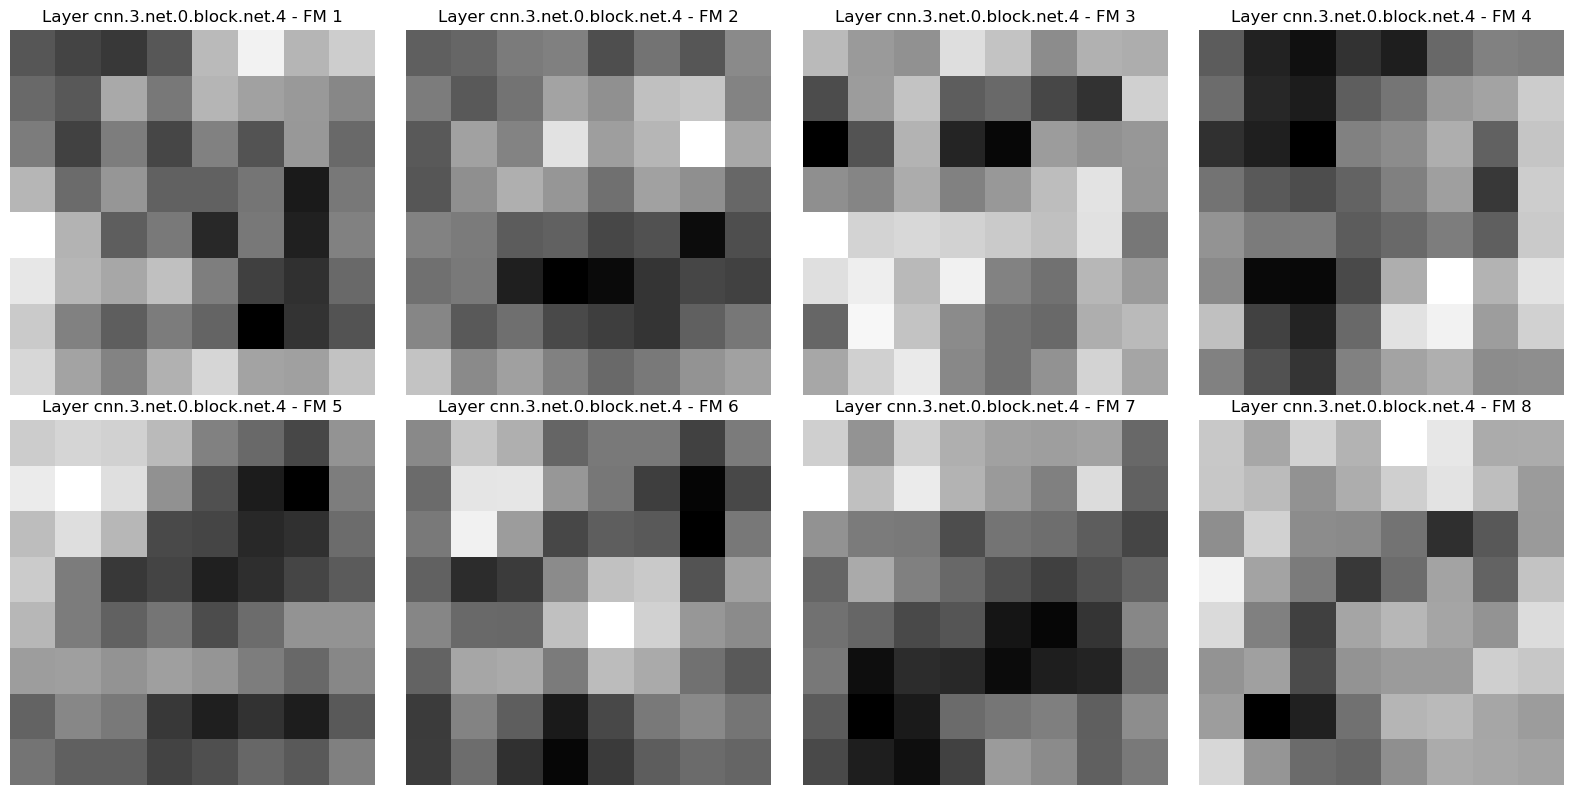

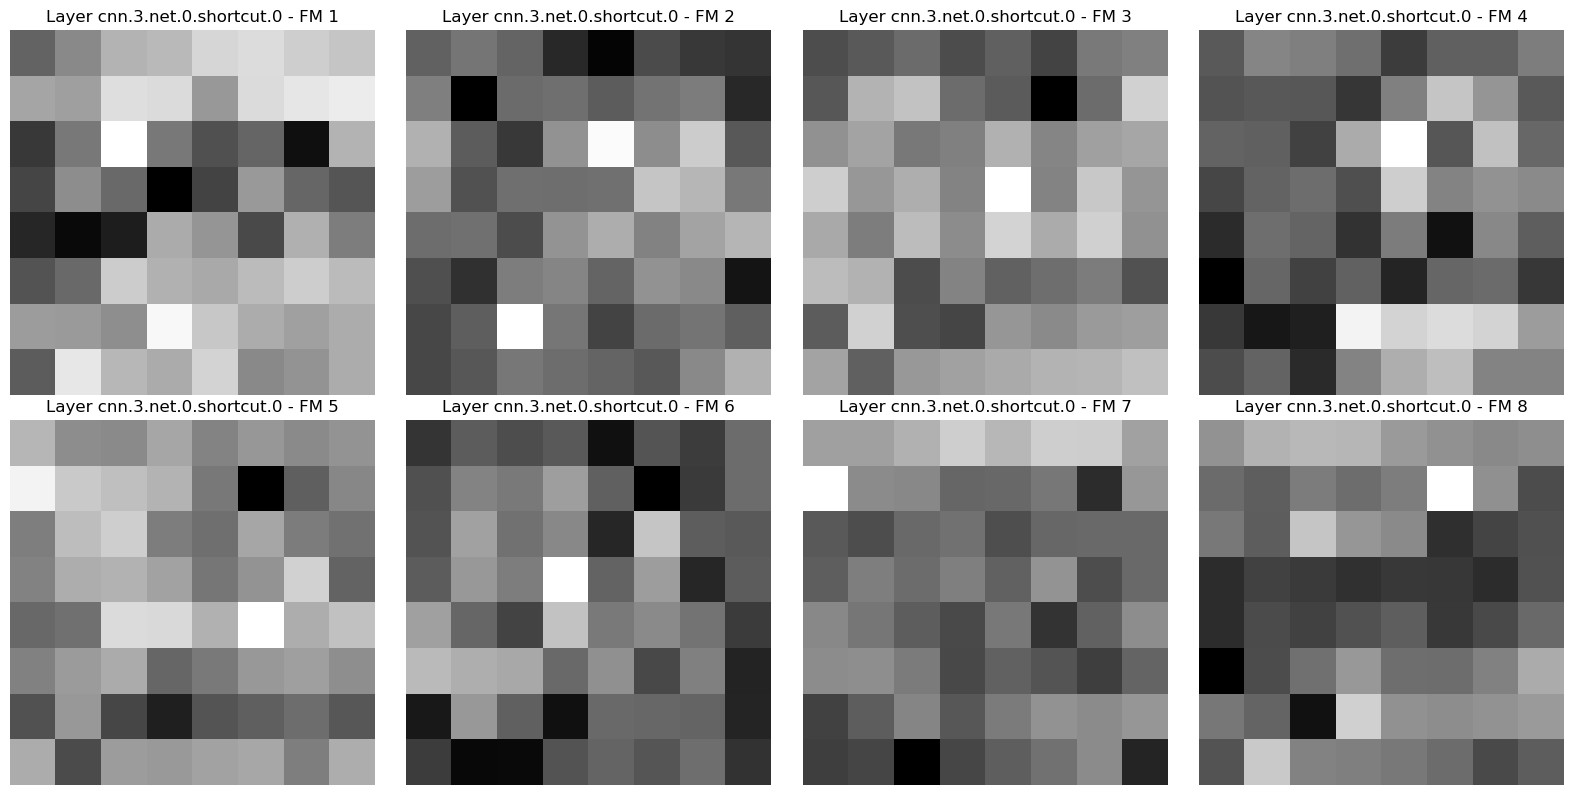

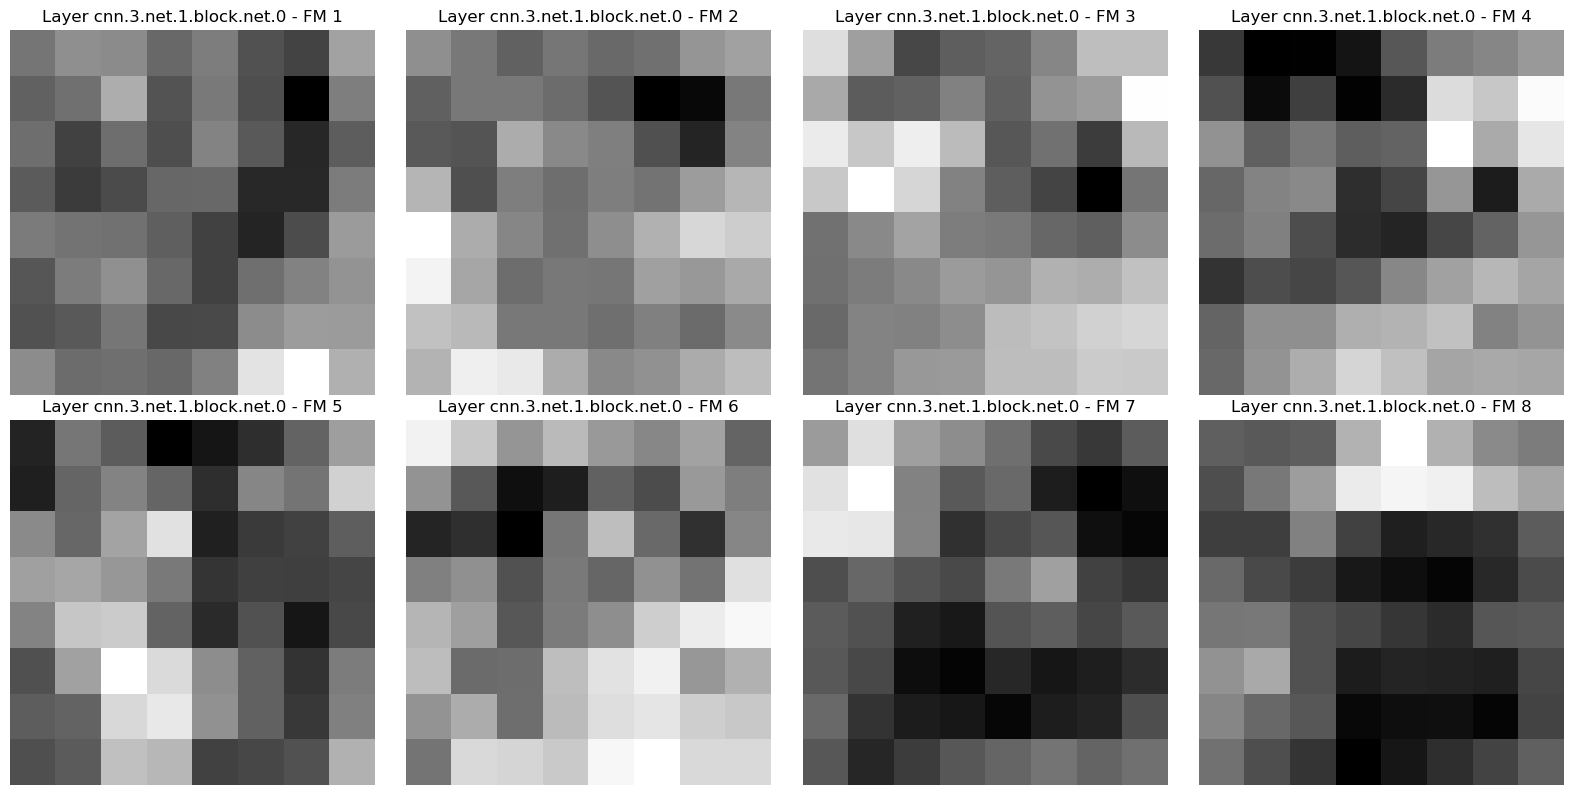

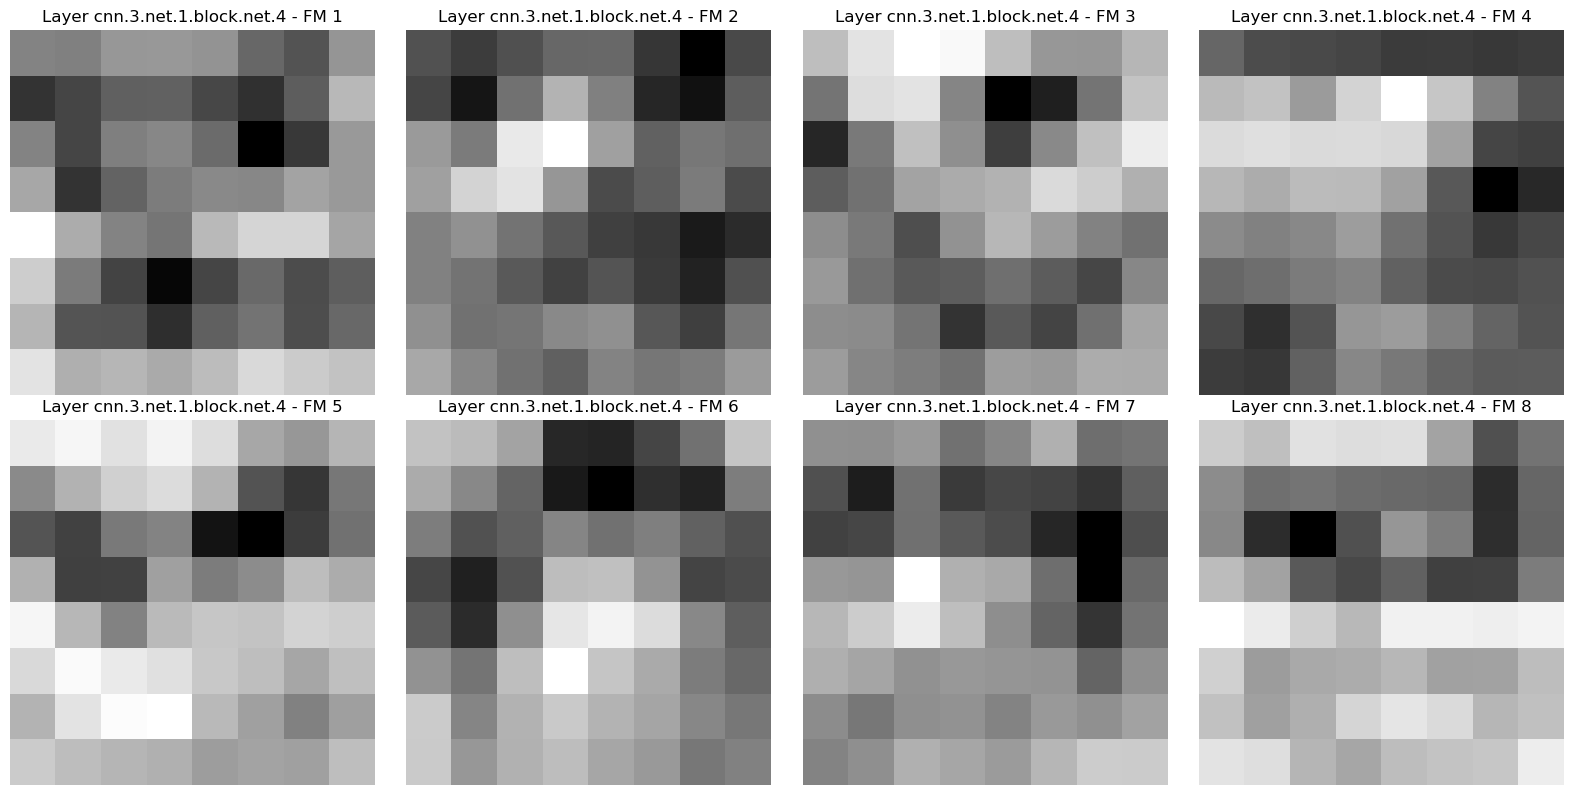

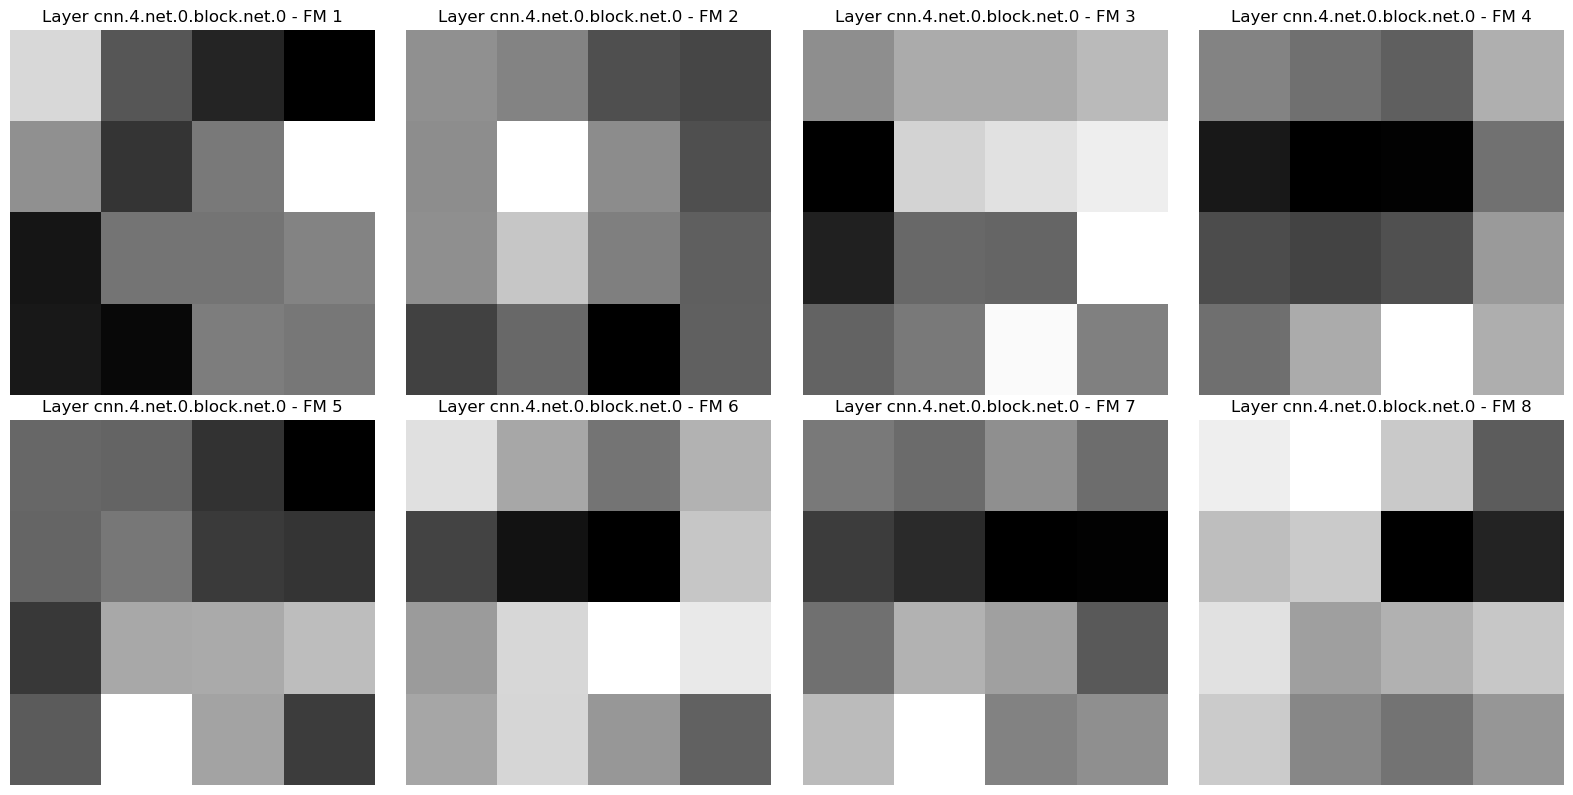

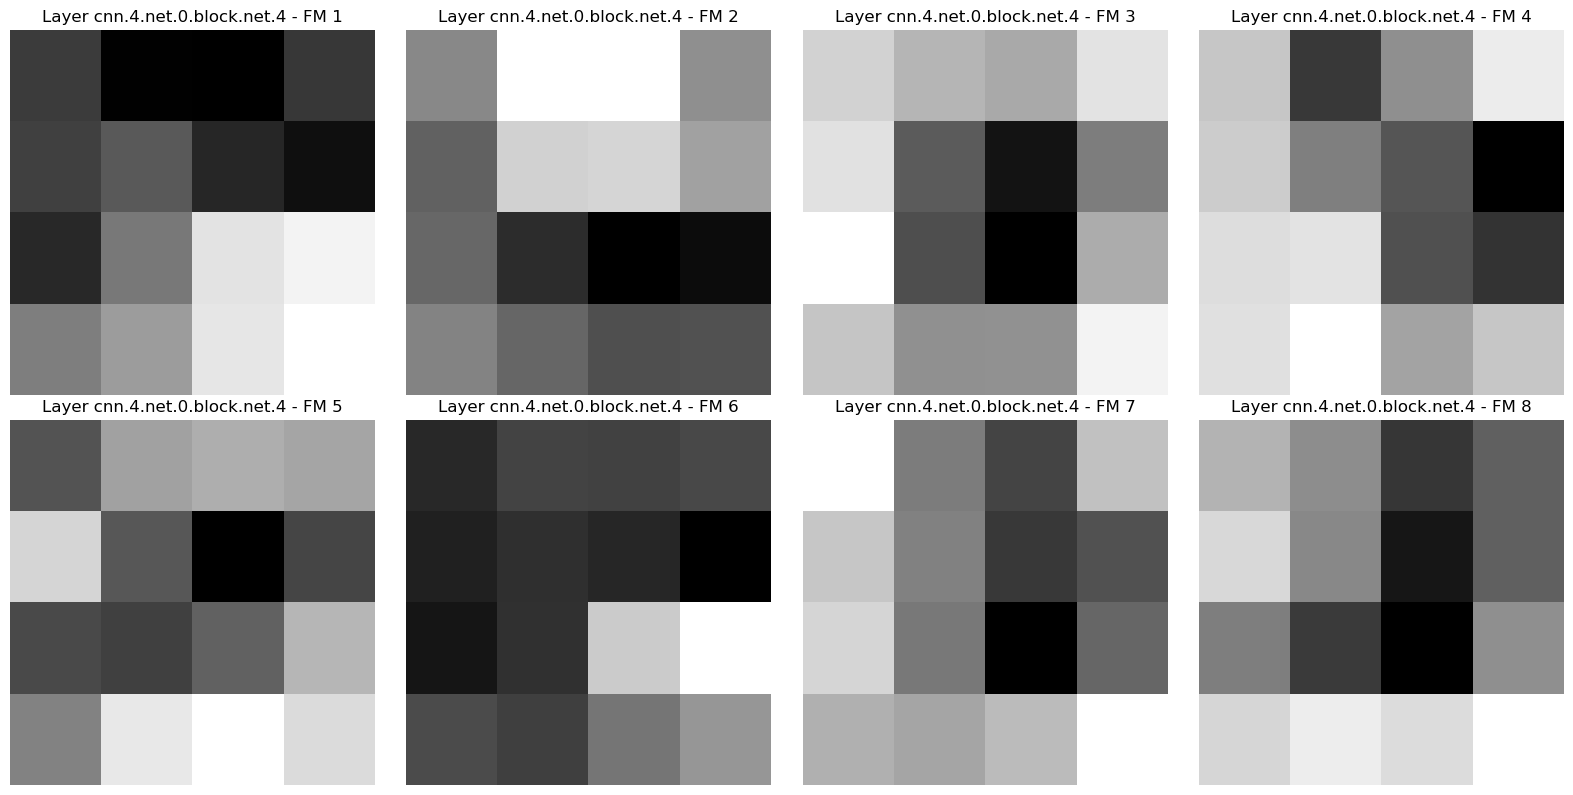

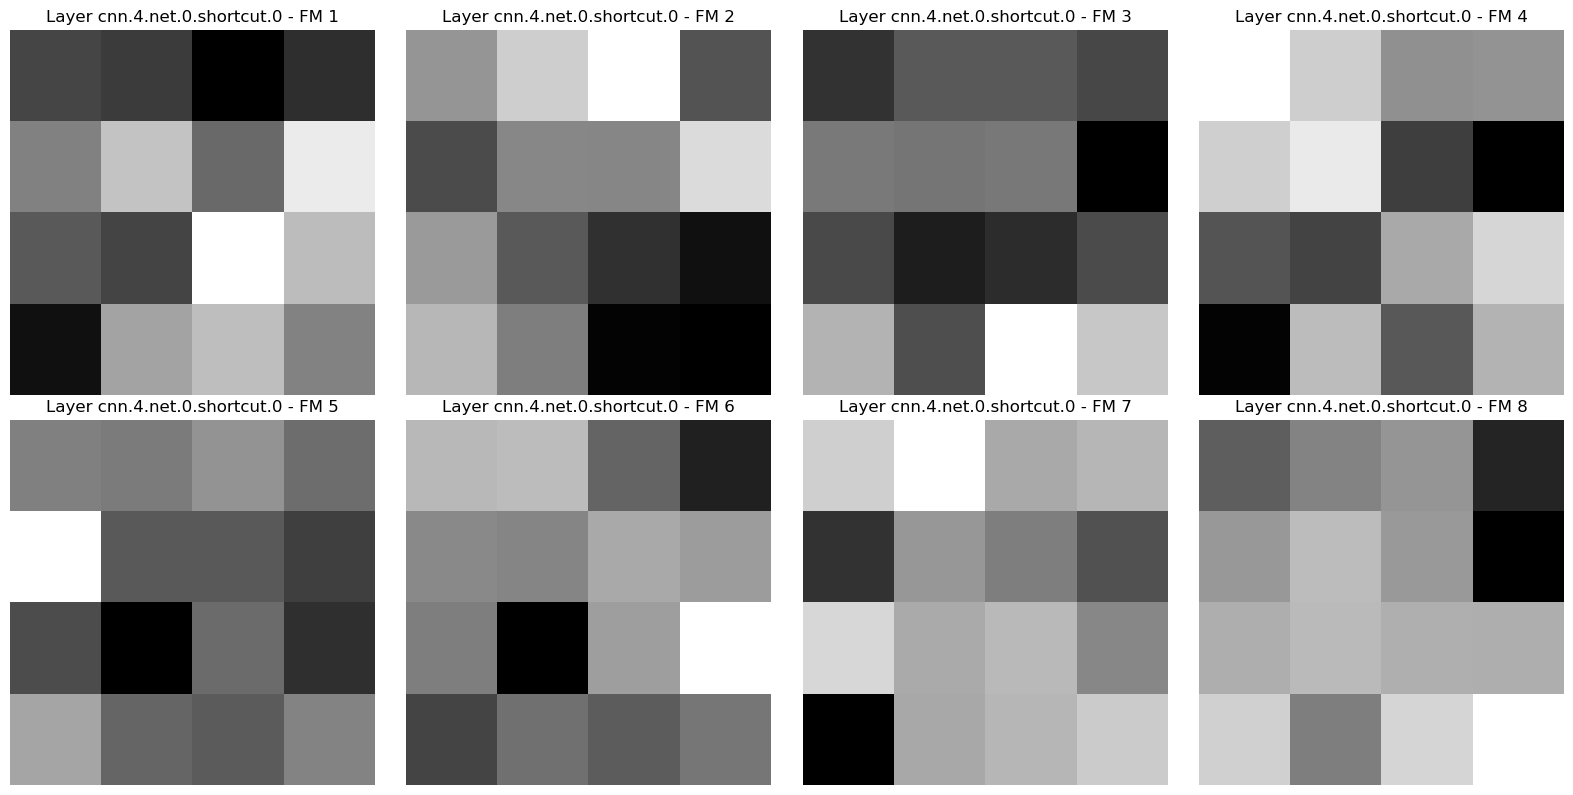

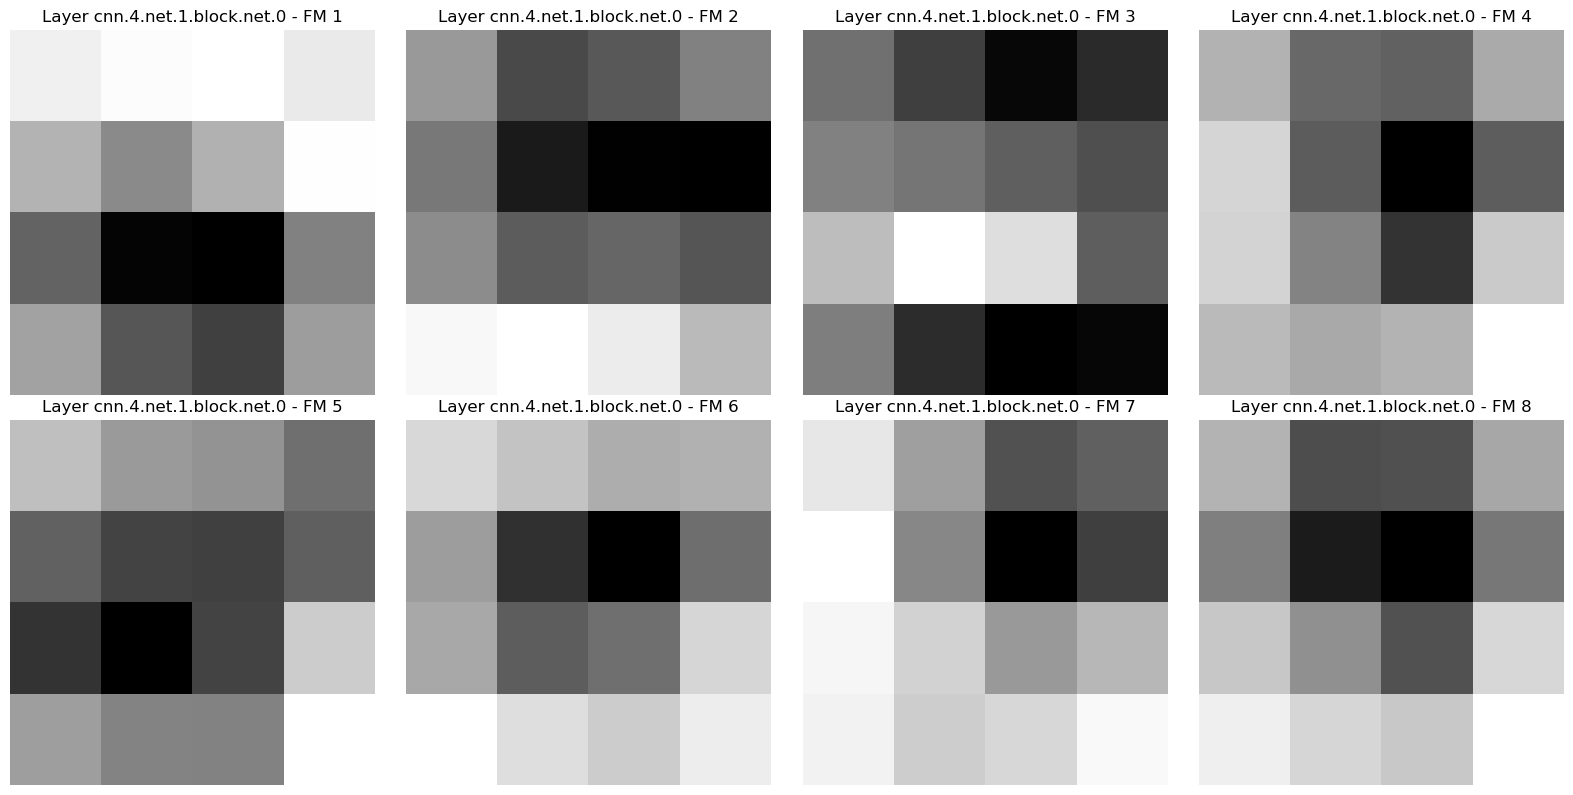

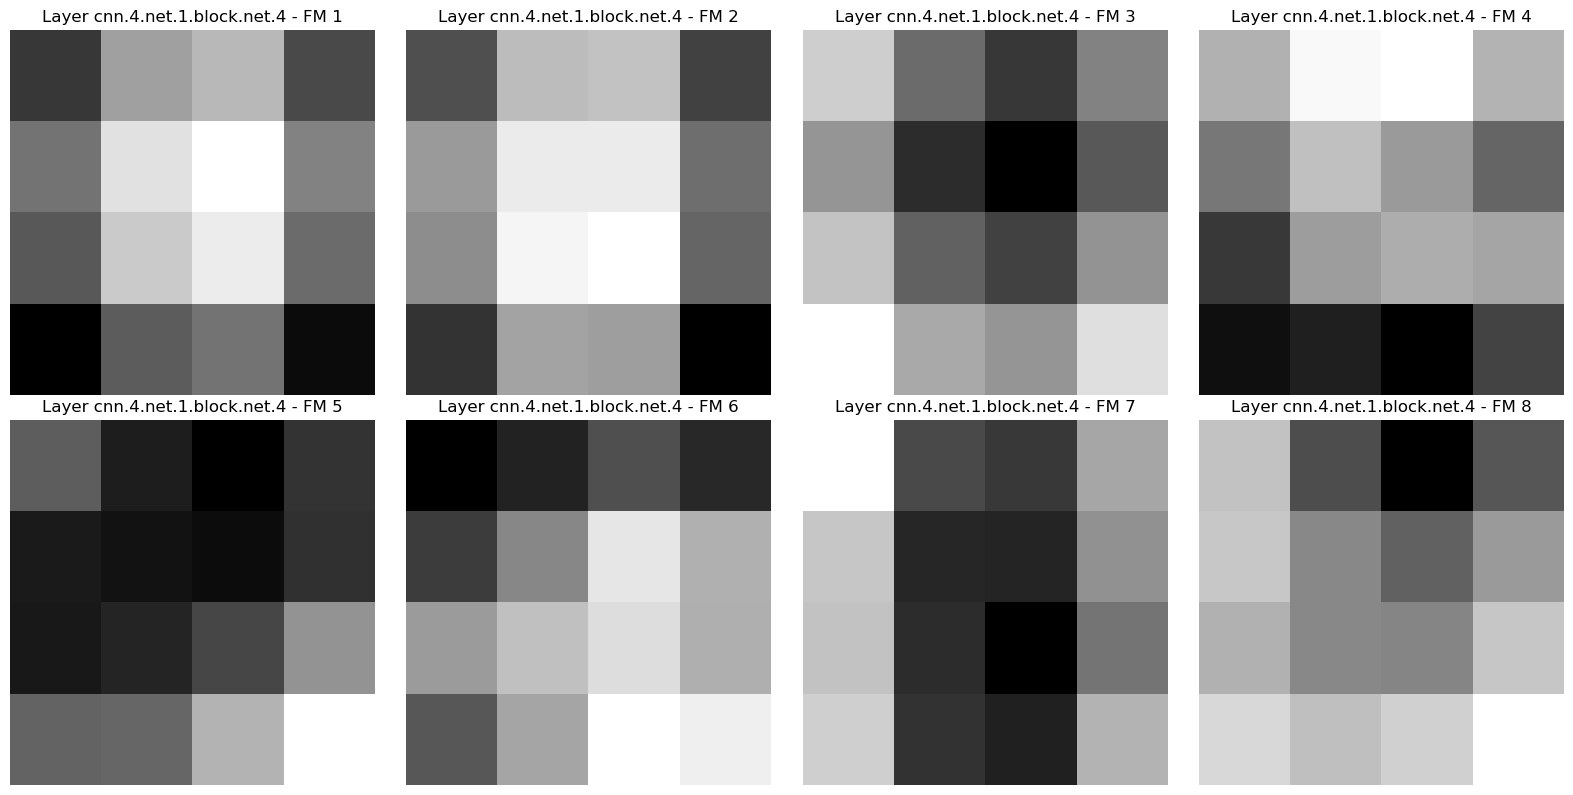

In [7]:
# Main workflow
name = 'best'
version = 1

model_path = f'./models/{name}_{version}.pth'
history_path = f'./history/{name}_{version}.pth'
checkpoint_path = f'./checkpoint/{name}_{version}.pth'

if os.path.exists(checkpoint_path):
    model = get_resnet(name).to(device)

    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    model = model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-3)
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    scheduler = CosineAnnealingLR(optimizer, T_max=100)
    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    train_acc_history = checkpoint['train_acc_history']
    val_acc_history = checkpoint['val_acc_history']
    lr_history = checkpoint['lr_history']

    # Plot training metrics together
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # Training and validation accuracy
    ax[0].plot(train_acc_history, label='Training Accuracy', marker='o')
    ax[0].plot(val_acc_history, label='Validation Accuracy', marker='o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy over Epochs')
    ax[0].legend()
    ax[0].grid(True)
    
    # Learning rate
    ax[1].plot(lr_history, marker='o', linestyle='-', color='b')
    ax[1].set_title("Learning Rate Schedule")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Learning Rate")
    ax[1].grid(True)
    
    # Loss history
    ax[2].plot(train_loss_history, marker='o', linestyle='-', color='b')
    ax[2].set_title("Loss History")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.show()

    # Register hooks
    register_hooks(model)

    # Check accuracy
    check_accuracy(loader_test, model, device='cuda')

    # Visualize intermediate layer outputs
    example_images, _ = next(iter(loader_test))
    example_images = example_images.to(device)
    _ = model(example_images)

    # Visualize feature maps
    for layer_name, feature_map in layer_outputs.items():
        visualize_feature_maps(feature_map, title_prefix=f"Layer {layer_name}")
else:
    print(name, '\n')
    model = get_resnet(name).to(device)
    model.apply(initialize_weights)
    optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=100)

    train_acc_history, val_acc_history, lr_history, train_loss_history = train_model(
        model, optimizer, loader_train, loader_val, device='cuda', epochs=100,checkpoint_path=checkpoint_path,
        schedule=[6, 15], scheduler=scheduler, verbose=False, model_path=model_path
    )

    torch.save(model.state_dict(), model_path)
    with open(history_path, 'wb') as f:
        pickle.dump((train_acc_history, val_acc_history, lr_history, train_loss_history), f)

    # Check accuracy
    check_accuracy(loader_test, model, device='cuda')

    # Plot training metrics together
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # Training and validation accuracy
    ax[0].plot(train_acc_history, label='Training Accuracy', marker='o')
    ax[0].plot(val_acc_history, label='Validation Accuracy', marker='o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy over Epochs')
    ax[0].legend()
    ax[0].grid(True)
    
    # Learning rate
    ax[1].plot(lr_history, marker='o', linestyle='-', color='b')
    ax[1].set_title("Learning Rate Schedule")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Learning Rate")
    ax[1].grid(True)
    
    # Loss history
    ax[2].plot(train_loss_history, marker='o', linestyle='-', color='b')
    ax[2].set_title("Loss History")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.show()


    # Register hooks and visualize
    register_hooks(model)
    example_images, _ = next(iter(loader_train))
    example_images = example_images.to(device)
    _ = model(example_images)
    for layer_name, feature_map in layer_outputs.items():
        visualize_feature_maps(feature_map, title_prefix=f"Layer {layer_name}")

In [8]:
print(model)

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBlock(
          (block): PlainBlock(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Dropout(p=0.4, inplace=False)
              (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (shortcut): Sequential(
            (0): Con